## Doublet Removal - scDblFinder
### Setup and Load Data
Data files are in the 'filtered_feature_bc_matrix' folder along with other output from CellRanger. 

On the question of whether to run cell filtering before or after doublet detection using scDblFinder the program authors say:


The input to scDblFinder should not include empty droplets, and it might be necessary to remove cells with a very low coverage (e.g. <200 reads) to avoid errors. Further quality filtering should be performed downstream of doublet detection, for two reasons: 1. the default expected doublet rate is calculated on the basis of the cells given, and if you excluded a lot of cells as low quality, scDblFinder might think that the doublet rate should be lower than it is. 2. kicking out all low quality cells first might hamper our ability to detect doublets that are formed by the combination of a good quality cell with a low-quality one. Unless QC filtering is very stringent (and it shouldn’t be!), it’s unlikely to make a big difference.

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import os 

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# data files are in the filtered matrix folder from CellRanger which has been renamed to the sample name
sample_name = r'sc69_1' #r'sc70_1' #r'sc72_1'
data_path = r"./raw_data/"
data_files_path = data_path + sample_name + r""

results_path = 'results/'
results_file = results_path + sample_name + '-db.h5ad'  # the file that will store the analysis results
metrics_file = results_path + sample_name + '_db_metrics.csv'  # the file that will store the metrics
# make results folder if it doesn't exist
if not os.path.exists(results_path):
    os.makedirs(results_path, exist_ok=False)

C:\Users\leeh1\McKinnonRosatiLab\jl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.10.3 anndata==0.11.0 umap==0.5.7 numpy==1.26.4 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


#### Setup R environment

In [30]:
import os
os.environ['R_HOME'] = r"C:\Program Files\R\R-4.4.2"  
import anndata2ri # order matters, comes after defining 'R_HOME
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%reload_ext rpy2.ipython

C:\Users\leeh1\AppData\Local\Temp\ipykernel_11240\364680306.py:9: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [54]:
%%R
.libPaths(c("C:/Users/leeh1/AppData/Local/R/win-library/4.4", .libPaths()))
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Loading required package: SeuratObject
Loading required package: sp

Attaching package: 'SeuratObject'

The following objects are masked from 'package:base':

    intersect, t

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: 'MatrixGenerics'

The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts,

#### Load data

Read in count data into an [`AnnData`](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object.  
The matrix.mtx file contains a sparse matrix of the counts.  
Barcodes file contains the sample names in the format: AAACCCAAGACCATAA-1  
Features file contains the gene id in the format: ENSMUSG00000051951, Xkr4, Gene Expression

The number of counts per cell will be relatively low since only UMIs are counted by Cellranger

In [55]:
adata = sc.read_10x_mtx(
    data_files_path,              # the directory with the `.mtx` file
    var_names='gene_symbols',     # use gene symbols for the variable names (variables-axis index)
    cache=True)                   # write a cache file for faster subsequent reading

# adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
print('Data matrix is sparse:', scipy.sparse.issparse(adata.X))
print()

# make the obs names unique by adding the sample name
adata.obs_names = [g.split("-")[0] + '_' + sample_name for g in adata.obs_names]
print(adata.obs_names[0:2])
print()
print('Number of cells =', f"{adata.n_obs:,.0f}")
print('Number of genes =', f"{adata.n_vars:,.0f}")
print('Number of counts =', f"{adata.X.sum():,.0f}")
print('Mean counts per cell =', f"{adata.X.sum()/adata.n_obs:,.0f}")
adata

... reading from cache file cache\raw_data-sc69_1-matrix.h5ad
Data matrix is sparse: True

Index(['AAACCTGAGACTAGAT_sc69_1', 'AAACCTGAGCGTAGTG_sc69_1'], dtype='object')

Number of cells = 10,929
Number of genes = 32,285
Number of counts = 45,368,196
Mean counts per cell = 4,151


AnnData object with n_obs × n_vars = 10929 × 32285
    var: 'gene_ids', 'feature_types'

In [56]:
n_cells = adata.n_obs
n_genes = adata.n_vars
n_counts = adata.X.sum()    
counts_per_cell = round(n_counts / n_cells)

df_metrics = pd.DataFrame([n_cells, n_genes, n_counts, counts_per_cell], \
                  index = ['Number of cells', 'Number of genes', 'Number of counts','Mean counts per cell']).T
df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].applymap('{:,.0f}'.format)
df_metrics.index = [sample_name]
df_metrics

C:\Users\leeh1\AppData\Local\Temp\ipykernel_11240\1815972615.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].applymap('{:,.0f}'.format)
C:\Users\leeh1\AppData\Local\Temp\ipykernel_11240\1815972615.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    32,285
Name: Number of genes, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].applymap('{:,.0f}'.format)
C:\Users\leeh1\AppData\Local\Temp\ipykernel_11240\1815972615.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    45,368,196
Name: Number of counts, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1

,Number of cells,Number of genes,Number of counts,Mean counts per cell
sc69_1,10929.0,"32,285","45,368,196","4,151"


### Detect doublets
Remove "empty" genes before doublet detection.

In [58]:
sc.pp.filter_genes(adata, min_cells=1)
df_metrics['Filter genes:'] = ' '
df_metrics['Number of genes removed'] = n_genes - adata.n_vars

filtered out 7350 genes that are detected in less than 1 cells


In [59]:
data_mat = adata.X.T                 # transform data matrix
doublet_ratio = n_cells/1000*0.008   # calculate multiplet rate based on 10x formula
print('multiplet rate = %4.1f' %(doublet_ratio*100), '%')

multiplet rate =  8.7 %


In [60]:
%%R -i data_mat -i doublet_ratio -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(SingleCellExperiment(list(counts=data_mat),), dbr=doublet_ratio)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~8744 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 2231 cells excluded from training.
iter=1, 2278 cells excluded from training.
iter=2, 2277 cells excluded from training.
Threshold found:0.516
1423 (13%) doublets called


In [71]:
doublets = [1.0 if x == 'doublet' else 0 for x in doublet_class]
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs["doublet"] = doublets

In [62]:
doublet_percentage = sum(doublets)/adata.n_obs*100
print('Doublet percentage = %4.1f' %(doublet_percentage))
df_metrics['Doublet removal:'] = ' '
df_metrics['Doublet percentage'] =  doublet_percentage

adata.obs.scDblFinder_class.value_counts()

Doublet percentage = 13.0


scDblFinder_class
singlet    9506
doublet    1423
Name: count, dtype: int64

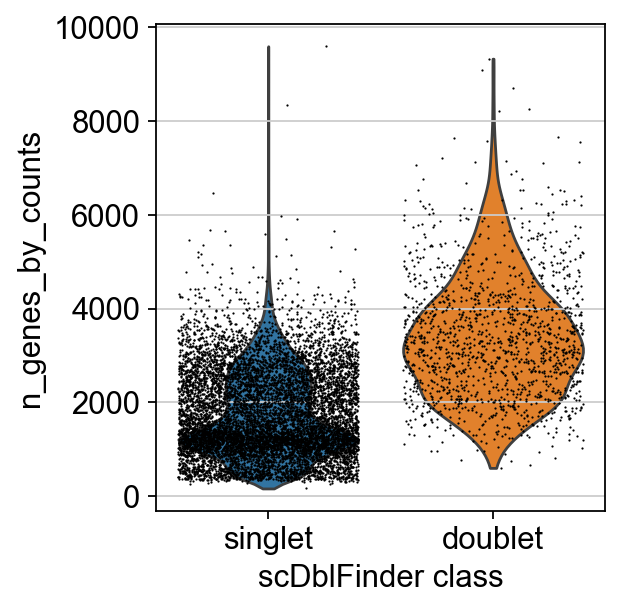

In [63]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4, groupby = 'scDblFinder_class')

In [74]:
num_before = adata.n_obs
singlets = adata.obs["scDblFinder_class"] == 'singlet'
num_after = adata[singlets].n_obs
n_genes = adata[singlets].n_vars
n_counts = adata[singlets].X.sum()    
counts_per_cell = round(n_counts / n_cells)

print('Number of cells before doublet removal =', num_before)
print('Number of cells after doublet removal =', num_after)
print('Number of cells removed =', num_before - num_after)
removed_percentage = (num_before - num_after)/num_before*100
print('Percentage of cells removed = %4.1f' %(removed_percentage))
n_counts = adata.X.sum()  
print('Number of counts =', f"{n_counts:,.0f}")
print('Mean counts per cell =', f"{counts_per_cell:,.0f}")

df_metrics['Number of cells removed'] =  num_before - num_after
df_metrics['After doublet removal:'] = ' '
df_metrics['Number of cells -db'] = num_after
df_metrics['Number of genes -db'] = n_genes
df_metrics['Number of counts -db'] = n_counts
df_metrics['Mean counts per cell -db'] = counts_per_cell

Number of cells before doublet removal = 10929
Number of cells after doublet removal = 9506
Number of cells removed = 1423
Percentage of cells removed = 13.0
Number of counts = 16,495,567
Mean counts per cell = 1,274


In [65]:
adata[singlets].write(results_file)
# print(adata)

In [66]:
df_metrics.T.to_csv(metrics_file)

### UMAP
Visualize the data before and after doublet removal.

In [67]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:58)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:15)


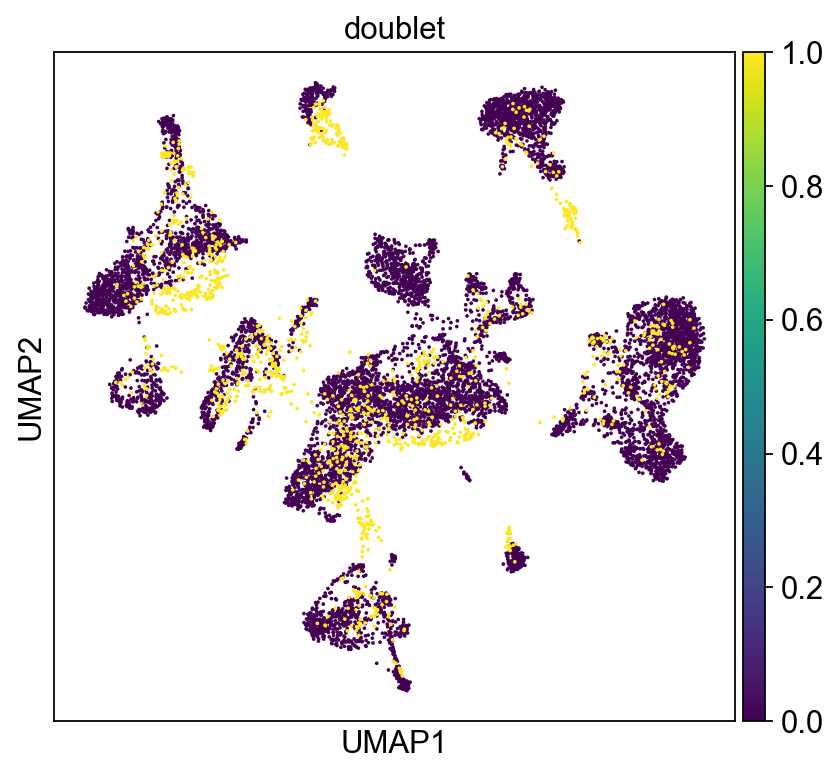

In [68]:
rcParams['figure.figsize'] = 6, 5.5
sc.pl.umap(adata, color=['doublet'])

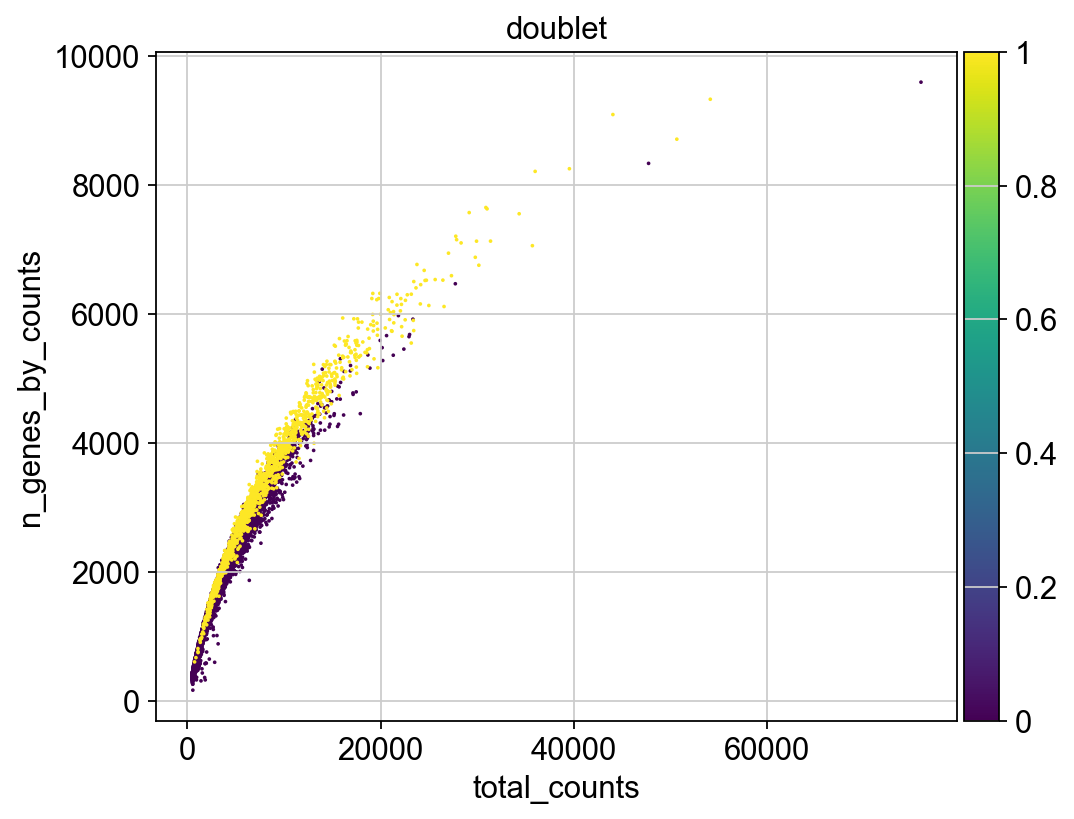

In [69]:
sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', color='doublet')